In [ ]:
!pip install tensorflow-gpu==2.6.2
!pip install Pillow
!pip install scipy

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

import numpy as np
import tensorflow as tf
print(tf.__version__)
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPool2D, Reshape
from tensorflow.keras.layers import LSTM

2.7.0


In [4]:
# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

In [3]:
acc = pd.read_csv('data/Activity recognition exp/Phones_accelerometer.csv')
gyro = pd.read_csv('data/Activity recognition exp/Phones_gyroscope.csv')

In [4]:
acc.rename(columns={'x': 'acc_x', 'y': 'acc_y','z': 'acc_z', 'gt': 'label'}, inplace=True)
acc = acc.drop('Index', 1)
acc = acc.drop('Creation_Time', 1)
acc = acc.drop('Model', 1)
acc = acc.drop('Device', 1)
acc

/tmp/ipykernel_29292/154202354.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  acc = acc.drop('Index', 1)
/tmp/ipykernel_29292/154202354.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  acc = acc.drop('Creation_Time', 1)
/tmp/ipykernel_29292/154202354.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  acc = acc.drop('Model', 1)
/tmp/ipykernel_29292/154202354.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  acc = acc.drop('Device', 1)


,Arrival_Time,acc_x,acc_y,acc_z,User,label
0,1424696633908,-5.958191,0.688065,8.135345,a,stand
1,1424696633909,-5.952240,0.670212,8.136536,a,stand
2,1424696633918,-5.995087,0.653549,8.204376,a,stand
3,1424696633919,-5.942718,0.676163,8.128204,a,stand
4,1424696633929,-5.991516,0.641647,8.135345,a,stand
...,...,...,...,...,...,...
13062470,1424778553315,1.379043,0.153227,9.959755,i,bike
13062471,1424778553346,1.379043,0.153227,9.806528,i,bike
13062472,1424778553366,1.532270,0.153227,9.806528,i,bike
13062473,1424778553386,1.532270,0.000000,9.959755,i,bike


In [6]:
gyro.rename(columns={'x': 'gyro_x', 'y': 'gyro_y','z': 'gyro_z', 'gt': 'label'}, inplace=True)
gyro = gyro.drop('Index', 1)
gyro = gyro.drop('Creation_Time', 1)
gyro = gyro.drop('Model', 1)
gyro = gyro.drop('Device', 1)
gyro

/tmp/ipykernel_29292/3097288041.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  gyro = gyro.drop('Index', 1)
/tmp/ipykernel_29292/3097288041.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  gyro = gyro.drop('Creation_Time', 1)
/tmp/ipykernel_29292/3097288041.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  gyro = gyro.drop('Model', 1)
/tmp/ipykernel_29292/3097288041.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  gyro = gyro.drop('Device', 1)


,Arrival_Time,gyro_x,gyro_y,gyro_z,User,label
0,1424696633909,0.013748,-0.000626,-0.023376,a,stand
1,1424696633909,0.014816,-0.001694,-0.022308,a,stand
2,1424696633918,0.015884,-0.001694,-0.021240,a,stand
3,1424696633919,0.016953,-0.003830,-0.020172,a,stand
4,1424696633928,0.015884,-0.007034,-0.020172,a,stand
...,...,...,...,...,...,...
13932627,1424778269892,-0.046844,0.337667,0.134677,i,bike
13932628,1424778269906,-0.117598,0.221777,0.131749,i,bike
13932629,1424778269920,-0.177617,0.056115,0.095152,i,bike
13932630,1424778269932,-0.195183,-0.124429,0.063191,i,bike


In [7]:
df = pd.merge(acc, gyro, how="inner", on=["Arrival_Time", "User", "label"])
df

,Arrival_Time,acc_x,acc_y,acc_z,User,label,gyro_x,gyro_y,gyro_z
0,1424696633908,-5.958191,0.688065,8.135345,a,stand,0.024129,-0.020769,0.008552
1,1424696633909,-5.952240,0.670212,8.136536,a,stand,0.013748,-0.000626,-0.023376
2,1424696633909,-5.952240,0.670212,8.136536,a,stand,0.014816,-0.001694,-0.022308
3,1424696633918,-5.995087,0.653549,8.204376,a,stand,0.015884,-0.001694,-0.021240
4,1424696633918,-5.995087,0.653549,8.204376,a,stand,0.023518,-0.017410,0.007636
...,...,...,...,...,...,...,...,...,...
12726170,1424778553235,1.532270,0.000000,9.806528,i,bike,-0.017624,0.005386,0.008514
12726171,1424778553256,1.379043,0.000000,9.959755,i,bike,-0.032693,-0.012687,-0.008539
12726172,1424778553286,1.532270,0.153227,9.959755,i,bike,-0.031717,-0.006831,-0.006099
12726173,1424778553306,1.379043,0.000000,9.959755,i,bike,-0.030741,-0.002928,-0.003904


In [10]:
df.to_csv('data/phones.csv')

In [5]:
phone = pd.read_csv('data/phones.csv')

In [6]:
df = phone.groupby(['User', 'label']).size()

In [7]:
df = pd.DataFrame({'count' : df}).reset_index()

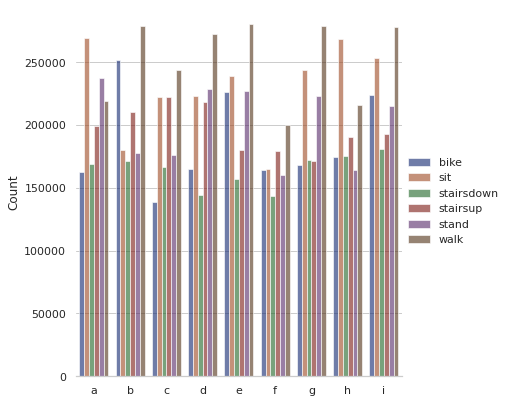

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="User", y="count", hue="label",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

In [9]:
phone_a = phone.loc[phone['User'] == 'a']

In [10]:
phone_a = phone_a.drop('Unnamed: 0', 1)
phone_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395809 entries, 0 to 1395808
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Arrival_Time  1395809 non-null  int64  
 1   acc_x         1395809 non-null  float64
 2   acc_y         1395809 non-null  float64
 3   acc_z         1395809 non-null  float64
 4   User          1395809 non-null  object 
 5   label         1255717 non-null  object 
 6   gyro_x        1395809 non-null  float64
 7   gyro_y        1395809 non-null  float64
 8   gyro_z        1395809 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 106.5+ MB


/tmp/ipykernel_469162/2294335862.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  phone_a = phone_a.drop('Unnamed: 0', 1)


In [11]:
phone_a = phone_a.dropna()
phone_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255717 entries, 0 to 1395808
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Arrival_Time  1255717 non-null  int64  
 1   acc_x         1255717 non-null  float64
 2   acc_y         1255717 non-null  float64
 3   acc_z         1255717 non-null  float64
 4   User          1255717 non-null  object 
 5   label         1255717 non-null  object 
 6   gyro_x        1255717 non-null  float64
 7   gyro_y        1255717 non-null  float64
 8   gyro_z        1255717 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 95.8+ MB


In [12]:
phone_a

,Arrival_Time,acc_x,acc_y,acc_z,User,label,gyro_x,gyro_y,gyro_z
0,1424696633908,-5.958191,0.688065,8.135345,a,stand,0.024129,-0.020769,0.008552
1,1424696633909,-5.952240,0.670212,8.136536,a,stand,0.013748,-0.000626,-0.023376
2,1424696633909,-5.952240,0.670212,8.136536,a,stand,0.014816,-0.001694,-0.022308
3,1424696633918,-5.995087,0.653549,8.204376,a,stand,0.015884,-0.001694,-0.021240
4,1424696633918,-5.995087,0.653549,8.204376,a,stand,0.023518,-0.017410,0.007636
...,...,...,...,...,...,...,...,...,...
1395804,1424698517360,6.895215,-1.685497,7.661350,a,bike,-0.132237,-0.711931,-0.464780
1395805,1424698517369,7.048442,-1.685497,7.661350,a,bike,0.294037,0.648132,-0.272675
1395806,1424698517369,7.048442,-1.685497,7.661350,a,bike,0.157791,0.748367,-0.664948
1395807,1424698517369,7.048442,-1.685497,7.661350,a,bike,0.110261,0.249844,0.091630


In [13]:
phone_a.groupby(['label', 'User']).size()

label       User
bike        a       162626
sit         a       268788
stairsdown  a       168575
stairsup    a       198806
stand       a       237528
walk        a       219394
dtype: int64

In [47]:
phone_a = phone_a.groupby(['label', 'User']).head(8000).reset_index(drop=True)
phone_a.groupby(['label', 'User']).size()

label       User
bike        a       8000
sit         a       8000
stairsdown  a       8000
stairsup    a       8000
stand       a       8000
walk        a       8000
dtype: int64

In [15]:
phone_a.to_csv('data/phones_user_a.csv')

In [16]:
X = phone_a[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]

In [17]:
y = phone_a[['label']]

In [18]:
# one hot encoding by pandas
y = pd.get_dummies(data=y, columns=['label'])
y.shape

(48000, 6)

In [19]:
#from sklearn.preprocessing import LabelEncoder

#def encode_df(dataframe):
#    le = LabelEncoder()
#    for column in dataframe.columns:
#        dataframe[column] = le.fit_transform(dataframe[column])
#    return dataframe

#encode the dataframe
#encode_df(y)
#y

In [20]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = (X.to_numpy())[train_index], (X.to_numpy())[test_index]
    y_train, y_test = (y.to_numpy())[train_index], (y.to_numpy())[test_index]

In [22]:
X_train.shape

(40000, 6)

In [23]:
y_train.shape

(40000, 6)

In [24]:
X_test.shape

(8000, 6)

In [25]:
y_test.shape

(8000, 6)

In [26]:
n_rows = X_train.shape[0]
n_cols = X_train.shape[1]
n_samples_train = int(n_rows/400)
n_samples_train = n_samples_train * 400
n_samples_train

40000

In [27]:
n_rows = X_test.shape[0]
n_cols = X_test.shape[1]
n_samples_test = int(n_rows/400)
n_samples_test = n_samples_test * 400
n_samples_test

8000

In [28]:
X_train = X_train[:n_samples_train,:]
X_train.shape

(40000, 6)

In [29]:
np.savetxt("data/X_train.csv", X_train, delimiter=",")
np.save('data/X_train.npy', X_train)

In [30]:
X_test = X_test[:n_samples_test,:]
X_test.shape

(8000, 6)

In [31]:
np.savetxt("data/X_test.csv", X_test, delimiter=",")
np.save('data/X_test.npy', X_test)

In [32]:
y_train = y_train[:n_samples_train,:]
y_train.shape

(40000, 6)

In [33]:
np.savetxt("data/y_train.csv", y_train, delimiter=",")
np.save('data/y_train.npy', y_train)

In [34]:
y_test = y_test[:n_samples_test,:]
y_test.shape

(8000, 6)

In [35]:
np.savetxt("data/y_test.csv", y_test, delimiter=",")
np.save('data/y_test.npy', y_test)

In [36]:
labels = y_train
labels.shape

(40000, 6)

In [37]:
n_instances = labels.shape[0]
n_attributes = labels.shape[1]
labels = labels.reshape(n_instances, n_attributes)
labels.shape

(40000, 6)

In [38]:
n_rows = X_train.shape[0]
n_cols = X_train.shape[1]
seg_shape = int(n_rows/400)
seg_shape = seg_shape * 400
seg_shape

40000

In [39]:
def windows(d, w, t):  
    r = np.arange(len(d))   
    s = r[::t]   
    z = list(zip(s, s + w))   
    f = '{0[0]}:{0[1]}'.format
    g = lambda t: d.iloc[t[0]:t[1]]   
    return pd.concat(map(g, z), keys=map(f, z))  

In [40]:
df = pd.DataFrame(X_train, columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])

In [41]:
segments = windows(df, 400, 1)
segments

acc_x     acc_y      acc_z    gyro_x    gyro_y    gyro_z
0:400       0     -5.958191  0.688065   8.135345  0.024129 -0.020769  0.008552
            1     -5.952240  0.670212   8.136536  0.013748 -0.000626 -0.023376
            2     -5.952240  0.670212   8.136536  0.014816 -0.001694 -0.022308
            3     -5.995087  0.653549   8.204376  0.015884 -0.001694 -0.021240
            4     -5.995087  0.653549   8.204376  0.023518 -0.017410  0.007636
...                     ...       ...        ...       ...       ...       ...
39997:40397 39998 -5.786804 -0.921066  10.832306 -0.123596  0.236908  0.222931
            39999 -5.786804 -0.921066  10.832306 -0.170593  0.246521  0.194092
39998:40398 39998 -5.786804 -0.921066  10.832306 -0.123596  0.236908  0.222931
            39999 -5.786804 -0.921066  10.832306 -0.170593  0.246521  0.194092
39999:40399 39999 -5.786804 -0.921066  10.832306 -0.170593  0.246521  0.194092

[15920200 rows x 6 columns]

In [42]:
n_samples = int(segments.shape[0]/400) * 400
segments = segments.head(n_samples)
segments.shape

(15920000, 6)

In [43]:
n_attributes = segments.shape[1]
X_train_windowed = (segments.to_numpy()).reshape(n_samples, 400, n_attributes)
X_train_windowed.shape

(39800, 400, 6)

In [44]:
np.save('data/X_train.npy', X_train_windowed)

In [45]:
y_train
y_train.shape

(40000, 6)

In [46]:
labels = y_train[:X_train_windowed.shape[0],:]
labels.shape

(39800, 6)

In [52]:
np.save('data/y_train.npy', labels)
labels

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=uint8)

In [48]:
tf.keras.backend.clear_session()

input = Input(shape=(2400,))
reshape_input = Reshape((1, 400, 6))(input)

x = Conv2D(32, kernel_size = (1, 24), 
        strides = (1, 1),  
        activation = "relu", 
        padding = "valid", 
        kernel_regularizer = l2(1e-4))(reshape_input)
x = MaxPool2D((1, 4), (1, 2))(x)

x = Conv2D(64, kernel_size = (1, 16), 
        strides = (1, 1), 
        activation = "relu", 
        padding = "valid", 
        kernel_regularizer = l2(1e-4))(x)
x = MaxPool2D((1, 4), (1, 2))(x)

x = Conv2D(96, kernel_size = (1, 8), 
        strides = (1, 1), 
        activation = "relu", 
        padding = "valid", 
        kernel_regularizer = l2(1e-4))(x)
x = MaxPool2D((1, 4), (1, 2))(x)

x = Conv2D(128, kernel_size = (1, 4), 
        strides = (1, 1), 
        activation = "relu", 
        padding = "valid", 
        kernel_regularizer = l2(1e-4),
        name="encoder")(x)        
x = Flatten()(x)
output = Dense(6, activation = "softmax")(x)

model = Model(input, output)
model.compile(optimizer = Adam(3e-4), 
              loss = "categorical_crossentropy",
              metrics = ["categorical_accuracy"])

2022-02-28 19:10:31.199460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:10:31.262545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-28 19:10:31.262561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-28 19:10:31.262934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [49]:
segments_reshaped = X_train_windowed.reshape(-1, 2400)
segments_reshaped.shape

(39800, 2400)

In [50]:
model.fit(segments_reshaped, labels, epochs = 20, 
          batch_size = 32, verbose = 2)

2022-02-28 19:10:39.736246: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 382080000 exceeds 10% of free system memory.
/home/ale/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
1244/1244 - 36s - loss: 0.1071 - categorical_accuracy: 0.9706 - 36s/epoch - 29ms/step
Epoch 2/20
1244/1244 - 36s - loss: 0.0225 - categorical_accuracy: 0.9984 - 36s/epoch - 29ms/step
Epoch 3/20
1244/1244 - 36s - loss: 0.0294 - categorical_accuracy: 0.9960 - 36s/epoch - 29ms/step
Epoch 4/20
1244/1244 - 36s - loss: 0.0234 - categorical_accuracy: 0.9978 - 36s/epoch - 29ms/step
Epoch 5/20
1244/1244 - 36s - loss: 0.0181 - categorical_accuracy: 0.9990 - 36s/epoch - 29ms/step
Epoch 6/20
1244/1244 - 35s - loss: 0.0254 - categorical_accuracy: 0.9976 - 35s/epoch - 28ms/step
Epoch 7/20
1244/1244 - 36s - loss: 0.0148 - categorical_accuracy: 0.9995 - 36s/epoch - 29ms/step
Epoch 8/20
1244/1244 - 35s - loss: 0.0180 - categorical_accuracy: 0.9983 - 35s/epoch - 28ms/step
Epoch 9/20
1244/1244 - 35s - loss: 0.0192 - categorical_accuracy: 0.9977 - 35s/epoch - 28ms/step
Epoch 10/20
1244/1244 - 35s - loss: 0.0133 - categorical_accuracy: 0.9993 - 35s/epoch - 28ms/step
Epoch 11/20
1244/1244 - 35s -

In [217]:
!rm -R par_model
!mkdir par_model

model = Model(model.input, model.get_layer("encoder").output)
tf.keras.models.save_model(model, "par_model", 
                           include_optimizer = False, 
                           save_format="tf")

2022-02-28 17:30:38.983905: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: par_model/assets


------------------

In [54]:
from tfltransfer import bases
from tfltransfer import heads
from tfltransfer import optimizers
from tfltransfer.tflite_transfer_converter import TFLiteTransferConverter

In [ ]:
    # --------------- on-device model conversion ---------------- #
    
    # on-device model configuration.
    num_classes = 6
    learning_rate = 0.001
    batch_size = 5
    l2_rate = 0.0001
    hidden_units = 128
    input_shape = model.get_layer(encoder_layer).output.shape
    input_shape = (1, 35,128)

    base = bases.SavedModelBase(tflite_model)

    head = Sequential([
        Flatten(input_shape=input_shape),
        Dense(units=hidden_units,
            activation="relu",
            kernel_regularizer=l2(l2_rate)),
        Dense(units=num_classes, 
            activation="softmax",
            kernel_regularizer=l2(l2_rate)),
    ])

    # Optimizer is ignored by the converter!
    head.compile(loss="categorical_crossentropy", optimizer="adam")

    converter = TFLiteTransferConverter(num_classes, 
                base,
                heads.KerasModelHead(head),
                optimizers.SGD(learning_rate),
                train_batch_size=batch_size) 
    
    converter.convert_and_save(tflite_ondevice_model)

In [59]:
base = bases.SavedModelBase("par_model")

head = Sequential([
    Flatten(input_shape=(1, 35, 128)),
    Dense(units=128,
        activation='relu',
        kernel_regularizer=l2(0.0001),
        input_shape=(256,)),
    Dense(units=2,
        activation='softmax',
        kernel_regularizer=l2(0.0001)),
])

# Optimizer is ignored by the converter! See docs.
head.compile(loss='categorical_crossentropy', optimizer='adam')

In [60]:
!rm -R tflite_par_model
!mkdir tflite_par_model

# TFLiteTransferConverter(num_classes, base_model, head_model, optimizer, train_batch_size)
converter = TFLiteTransferConverter(labels.shape[1],
              base,
              heads.KerasModelHead(head),
              optimizers.SGD(0.001),
              train_batch_size=5)

converter.convert_and_save('tflite_par_model')

AttributeError: 'NoneType' object has no attribute 'op'

--------------------